<h2>Import library and Data</h2>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import itertools
from os import path
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import json
import pickle
# set the random seeds to make sure your results are reproducible
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
tf.random.set_seed(1)

# specify path to training data and testing data

folderbig = "small"
foldersmall = "small"

train_x_location = folderbig + "/" + "x_train.csv"
train_y_location = folderbig + "/" + "y_train.csv"
test_x_location = foldersmall + "/" + "x_test.csv"
test_y_location = foldersmall + "/" + "y_test.csv"



print("Reading training data")
x_train_2d = pd.read_csv(train_x_location,header = None)
y_train = pd.read_csv(train_y_location,names = ["label"])


print("Reading testing data")
x_test_2d = np.loadtxt(test_x_location, dtype="uint8", delimiter=",")
x_test_3d = x_test_2d.reshape(-1,28,28,1)
x_test = x_test_3d
y_test = np.loadtxt(test_y_location, dtype="uint8", delimiter=",")






Reading training data
Reading testing data


<h2>Clean the data if need</h2>
<h2>Reshape and Rescale the data</h2>

In [2]:
# clean data

# drop the data with None
# x_train_2d.at[1, 1] = None
#======= for drop null
# result = pd.concat([y_train, x_train_2d], axis=1)#merge x,y
# result.dropna(inplace = True)#remove row with null
# y_train = pd.DataFrame(data=result[0])#split the x,y
# x_train_2d = result.iloc[:,1:]
#======= 

#x_train_2d.fillna(method = 'bfill',inplace = True)#replace null with backward
#x_train_2d.fillna(0,inplace = True)#replace null with 0
#x_train_2d.isnull().values.sum()#check the null number
#result


x_train_3d = x_train_2d.values.reshape(-1,28,28,1)
x_train = x_train_3d

print("Pre processing x of training data")
x_train = x_train / 255.0


Pre processing x of training data


<h2>Turn the label to one hot</h2>
<h2>Split the training data for validation</h2>

In [3]:
#categorical_crossentropy: for one hot label
y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)

random_seed = 2
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.8, random_state=random_seed)
# define the training model

<h2>[Optional] Show the Data</h2>

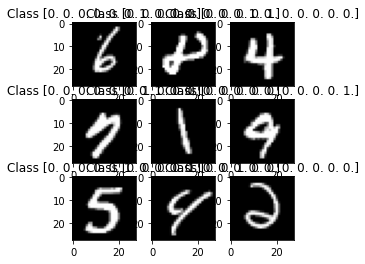

In [4]:

# show some sample
#g = plt.imshow(x_train[0][:,:,0])
plt.figure(figsize=(4,4))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap="gray")
    plt.title("Class %s" %y_train[i])

<h2>[Optional] Data Augmentation by shift and rotation</h2>


In [5]:
# gen = ImageDataGenerator(featurewise_center=False,
#                          samplewise_center=False,
#                          rotation_range=8, 
#                          width_shift_range=0.08, 
#                          shear_range=0.3,
#                          height_shift_range=0.08, 
#                          zoom_range=0.08,
#                          data_format="channels_last")
# gen.fit(x_train)
# train_generator = gen.flow(x_train, y_train, batch_size=300)


<h2>Design the Model</h2>

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

<h2>Design Learning Rate Rule</h2>
<h2>Design Optimizer</h2>

In [7]:
learning_rate_function = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, #val_acc not improve 3 times in rows
                                            verbose=1, 
                                            factor=0.5, #learing rate *0.5
                                            min_lr=0.00001)# minimum learing rate
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

#sparse_categorical_crossentropy:for int label
#categorical_crossentropy: for one hot label
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])



<h2>Training or Loading Model</h2>

In [20]:
modelName = "cnn_model.h5"
if path.exists(modelName):
    print("Load the model from",modelName)
    f = open(modelName, 'rb')
    new_model = tf.keras.models.load_model(modelName)
    f.close()
else:
    print("train")
    # train the augmented data
    # train_history = model.fit_generator(train_generator, 
    #                                     steps_per_epoch=300, 
    #                                     epochs=1, 
    #                                     verbose=1,
    #                                     callbacks=[learning_rate_function])

    #train_history = model.fit(x_train, y_train, batc_size=200,epochs=10,callbacks=[learning_rate_function])
    train_history = model.fit(x_train, y_train, batc_size=200,epochs=10,callbacks=[learning_rate_function],validation_data = (x_val,y_val))

    #validation_split split data for validate the accuracy
    #verbose log
    model.save('cnn_model.h5')

train
Epoch 1/10
38/38 [==============================] - 4s 100ms/step - loss: 1.2344 - accuracy: 0.5917 - val_loss: 0.5627 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 2/10
38/38 [==============================] - 4s 97ms/step - loss: 0.5491 - accuracy: 0.8342 - val_loss: 0.4415 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 3/10
38/38 [==============================] - 4s 100ms/step - loss: 0.3506 - accuracy: 0.8817 - val_loss: 0.2807 - val_accuracy: 0.9154 - lr: 0.0010
Epoch 4/10
38/38 [==============================] - 4s 100ms/step - loss: 0.2597 - accuracy: 0.9167 - val_loss: 0.2336 - val_accuracy: 0.9315 - lr: 0.0010
Epoch 5/10
38/38 [==============================] - 4s 100ms/step - loss: 0.2083 - accuracy: 0.9325 - val_loss: 0.2333 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 6/10
38/38 [==============================] - 4s 101ms/step - loss: 0.1613 - accuracy: 0.9500 - val_loss: 0.2226 - val_accuracy: 0.9317 - lr: 0.0010
Epoch 7/10
38/38 [==============================] - 4s 98ms/step 

<h2>[Optional] Load the Model Training History</h2>

In [22]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params
historyName = 'history'
if path.exists(historyName):
    with open(historyName, 'rb') as file:
        train_history=pickle.load(file)

<h2>[Optional] Save the Model Training History</h2>

In [10]:


with open(historyName, 'wb') as file:
    model_history= History_trained_model(train_history.history, train_history.epoch, train_history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)
    

<h2>[Optional] Test the Model Predict</h2>
<h2>[Optional] Model Summary</h2>


In [11]:
tmp = model.predict(x_train[:1], batch_size=None, verbose=0, steps=None)
print(tmp)
tmp = np.argmax(tmp,axis = 1)
print(tmp)
print(model.summary())

[[0.09489588 0.1062435  0.09030205 0.10101804 0.10385548 0.09818225
  0.10387287 0.10923535 0.09112681 0.10126775]]
[7]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  160       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1605888   
__

<h2>[Optional] Training and validation curves</h2>
<h3>if training accuracy > validation accuracy: overfit</h3>

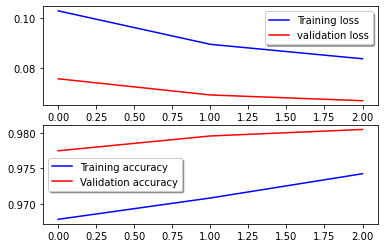

In [12]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(train_history.history['loss'], color='b', label="Training loss")
ax[0].plot(train_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(train_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

<h2>[Optional] Defined confusion matrix</h2>


In [13]:
# visualization of the performance of an algorithm.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h2>[Optional] Plot confusion matrix</h2>
<h3>check the class correlation</h3>

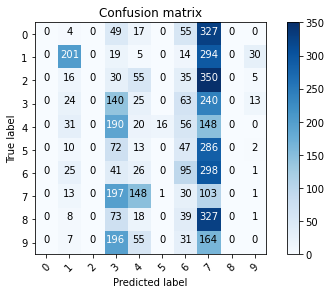

In [14]:
# Predict the values from the validation dataset
y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

<h2>Evaluate Model</h2>


In [15]:

print("Pre processing testing data")
x_test = x_test / 255.0

print("evaluate")
model.evaluate(x_test, y_test)

Pre processing testing data
evaluate
188/188 [==============================] - 2s 12ms/step - loss: 2.3082 - accuracy: 0.1198


[2.308157444000244, 0.1198333352804184]

<h2>[Optional] Show the error results</h2>

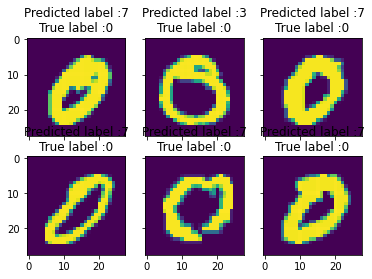

In [16]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

<h2>[Optional] Predict All test</h2>

In [17]:
# predict results
results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

<h2>[Optional] Save Predict Result</h2>

In [18]:
submission = pd.concat([pd.Series(range(0,len(x_test)),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)
submission

,ImageId,Label
0,0,9
1,1,3
2,2,6
3,3,7
4,4,7
...,...,...
5995,5995,7
5996,5996,7
5997,5997,7
5998,5998,7


<h2>[Optional] Show test Image</h2>

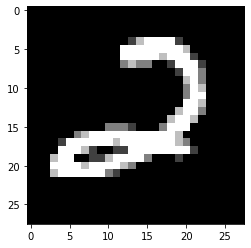

In [19]:
plt.imshow(x_test[5999].reshape(28,28), cmap="gray")